In [74]:
import os
import struct
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import pymongo
%matplotlib inline

In [75]:
'''
Functions needed:
    parse file tree
    construct mongodb
    populate mongodb with file structure
    Add EEG report to db
'''

'\nFunctions needed:\n    parse file tree\n    construct mongodb\n    populate mongodb with file structure\n    Add EEG report to db\n'

In [76]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = label
        self.sampleRate = sampleRate
        self.transducer = transducer
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = channelIndex
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            return "Label: " + str(self.label) + "\nIndex: " + str(self.channelIndex) + "\nSample Rate: "+str(self.sampleRate)
                    
        
    def returnChannelData(self,start,duration,channelNumber):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time of record desired in seconds
        '''
        toReturn = []
        seekLocation = int(self.channelIndex + start*2) #Why *2 here?????
        numberOfBytes = int(self.sampleRate) * duration 
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            toReturn.append(value)
            
        return toReturn
    
    def returnChannelDataForGraph(self,start,duration,channelNumber):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time of record desired in seconds
        ##########This might be easier to do within original edf class
        '''
        toReturn = []
        seekLocation = int(self.channelIndex + start*2)
        numberOfBytes = int(self.sampleRate) * duration 
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            value -= channelNumber*256
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn
        
    def channelIndex(self):
        return self.channelIndex
    
    def returnLabel(self):
        return self.label
    
    def notes(self):
        return self.notes
    
    

In [77]:
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nheader Bytes: " 
                + str(self.headerBytes) + "\nNum Records :" 
                + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nFile Size: "+str(self.fileSize) + "\nDuration: "+str(self.duration))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def printId(self):
        print("File Id: "+str(self.fileId))
   
    def fileParams(self):
        print(("File Size: "+str(self.fileSize)))
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(100000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
        
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = self.edfRawData.read(8)
        self.patientId = self.edfRawData.read(80)
        self.recordId = self.edfRawData.read(80)
        self.startDate = self.edfRawData.read(8)
        self.startTime = self.edfRawData.read(8)
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = self.edfRawData.read(44)
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = self.edfRawData.read(8)
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.edfRawData.read(self.nSignals*16).split()
        self.channels['transducer'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['dimensions'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['preFilter'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['sampleRate'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['reservedNotes'] = self.edfRawData.read(self.nSignals*32).split()
        
        self.channelObjects = []
        self.sampleRate = self.channels['sampleRate'][0]
        channelDataStart = self.headerBytes
        
        #This loop creates and add channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords*i*2
            channelIndex = channelDataStart + byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelIndex,byteLength))
            
             
    def returnDuration(self):
        return self.duration
    
    def returnRecords(self):
        return self.nRecords
    
    def returnNumSignals(self):
        return self.nSignals

    def returnChannelLabels(self):
        labels = []
        for x in self.channelObjects:
            labels.append(x.returnLabel())
        return labels
            
    def returnData(self,start,duration):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.returnLabel(),x.returnChannelData(start,duration,j)])
            j+=1
        return sampleData
    
    def returnDataForGraph(self,start,duration):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.returnLabel(),x.returnChannelDataForGraph(start,duration,j)])
            j+=1
        return sampleData
    
    def returnSampleRate(self):
        return self.sampleRate  
    
    def returnTotalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[0])

In [78]:
print(edfFile1)

version: b'0       '
header Bytes: 8448
Num Records :20
Num Signals :32
File Size: 520448
Duration: b'1.000000'


In [79]:
edfFile1 = edfData(1)
edfFile1.loadFile("v1.2.0/eval/01_tcp_ar/00000258/s002_2003_07_21/00000258_s002_t000.edf")
edfFile1.parseEdf()

edfFile2 = edfData(1)
edfFile2.loadFile("v1.2.0/eval/01_tcp_ar/00001027/s003_2004_01_29/00001027_s003_t000.edf")
edfFile2.parseEdf()

print(edfFile2.returnSampleRate(),"\n")
print(edfFile2.returnChannelLabels(),"\n")
print(edfFile2.returnDuration(),"\n")
print(edfFile2.returnNumSignals(),"\n")
print("Records: ",edfFile2.returnRecords(),"\n")
print("Num Samples: ",edfFile2.returnTotalSamples(),"\n")


print(edfFile1.returnSampleRate(),"\n")
print(edfFile1.returnChannelLabels(),"\n")
print(edfFile1.returnDuration(),"\n")
print(edfFile1.returnNumSignals(),"\n")
print("Records: ",edfFile1.returnRecords(),"\n")
print("Num Samples: ",edfFile1.returnTotalSamples(),"\n")
edfFile1.testChannelPrint()
print(edfFile1)


b'400' 

[b'EEG', b'FP1-REF', b'EEG', b'FP2-REF', b'EEG', b'F3-REF', b'EEG', b'F4-REF', b'EEG', b'C3-REF', b'EEG', b'C4-REF', b'EEG', b'P3-REF', b'EEG', b'P4-REF', b'EEG', b'O1-REF', b'EEG', b'O2-REF', b'EEG', b'F7-REF', b'EEG', b'F8-REF', b'EEG', b'T3-REF', b'EEG', b'T4-REF', b'EEG', b'T5-REF', b'EEG', b'T6-REF'] 

b'1.000000' 

32 

Records:  464 

Num Samples:  185600 

b'400' 

[b'EEG', b'FP1-REF', b'EEG', b'FP2-REF', b'EEG', b'F3-REF', b'EEG', b'F4-REF', b'EEG', b'C3-REF', b'EEG', b'C4-REF', b'EEG', b'P3-REF', b'EEG', b'P4-REF', b'EEG', b'O1-REF', b'EEG', b'O2-REF', b'EEG', b'F7-REF', b'EEG', b'F8-REF', b'EEG', b'T3-REF', b'EEG', b'T4-REF', b'EEG', b'T5-REF', b'EEG', b'T6-REF'] 

b'1.000000' 

32 

Records:  20 

Num Samples:  8000 

Label: b'EEG'
Index: 8448
Sample Rate: b'400'
version: b'0       '
header Bytes: 8448
Num Records :20
Num Signals :32
File Size: 520448
Duration: b'1.000000'


In [80]:


#print ("Buffer Bytes: "+str(sys.getsizeof(plotData)))

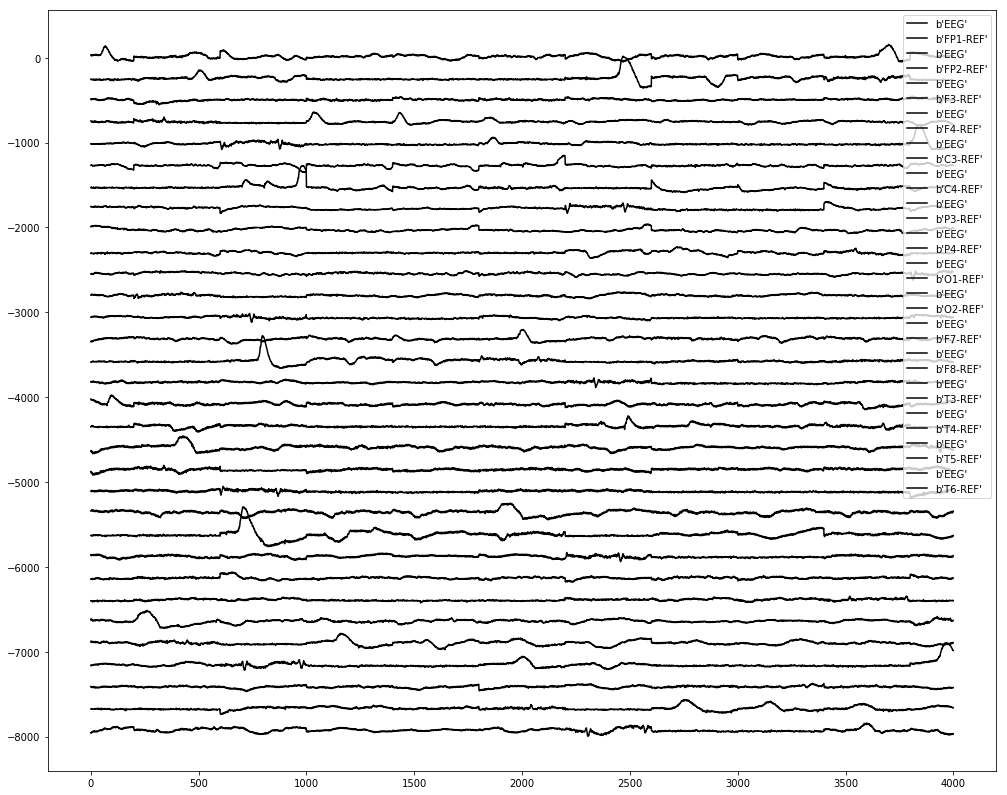

In [81]:
plotData = edfFile1.returnDataForGraph(600,10)
plt.figure(figsize=(17,14))
for x in plotData:
    plt.plot(x[1],color='black',label=x[0])
plt.legend()

In [82]:
channel1 = np.array(plotData2[5])
x = np.sin(channel1)
con1 = np.convolve(channel1,x)

NameError: name 'plotData2' is not defined

b'F3-REF'


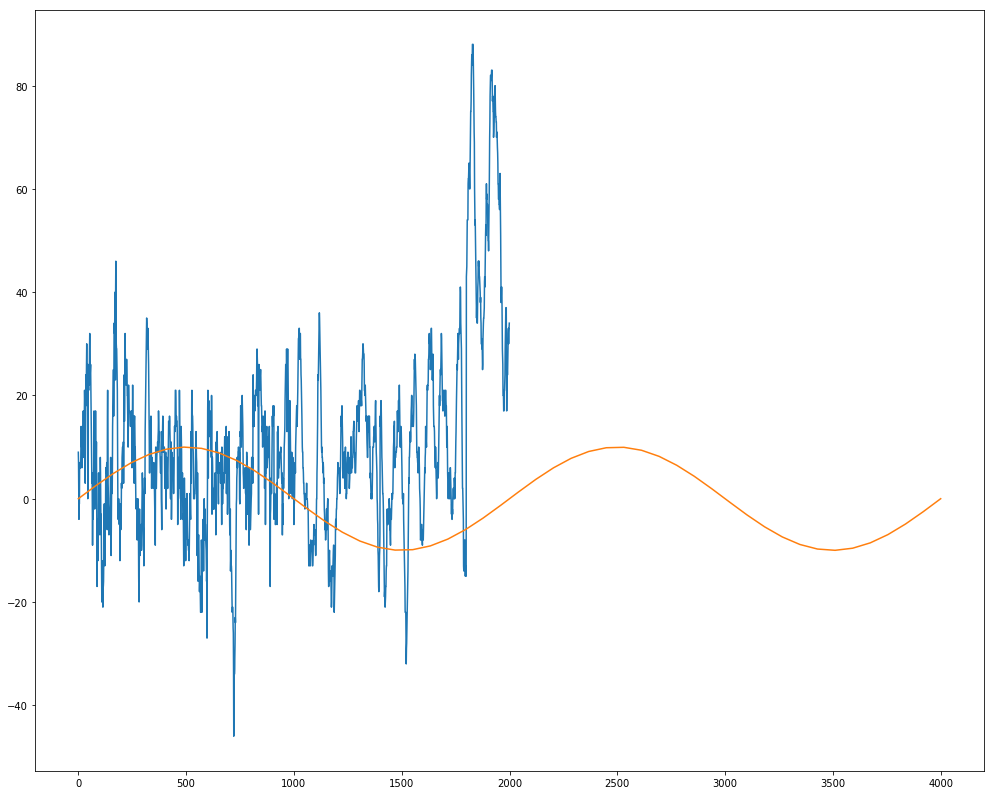

In [88]:
plotData2 = edfFile2.returnData(7000,5)
channel1 = plotData2[5]
plt.figure(figsize=(17,14))
plt.plot(channel1[1],label=channel1[0])
x = np.linspace(0,4000)
plt.plot(x, 10*np.sin(x*np.pi/1000),label="Sine Wave")
print (channel1[0])

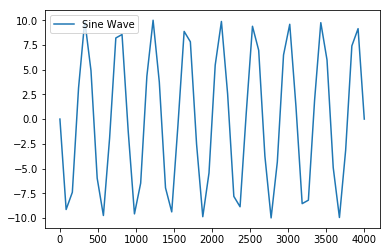

In [84]:
x = np.linspace(0,4000)
plt.plot(x, 10*np.sin(x*np.pi),label="Sine Wave")
plt.legend()

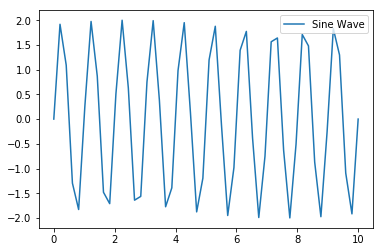

In [85]:
x = np.linspace(0,10)
plt.plot(x,2*np.sin(x*np.pi*2),label="Sine Wave")
plt.legend()